# Word2Vec (Skipgram ) with Negative Sampling

### Library Imports

This section imports all the necessary libraries required for the project. The libraries are used for various purposes such as numerical operations, deep learning model creation and optimization, data visualization, and natural language processing. Specifically:

- `numpy`: Fundamental package for scientific computing with Python.
- `torch`: A deep learning framework that provides a flexible platform for research and production.
- `torch.nn`: A sub-library of PyTorch for building neural networks.
- `torch.optim`: A sub-library of PyTorch for optimizing models.
- `matplotlib`: A plotting library for creating static, interactive, and animated visualizations in Python.
- `nltk`: A leading platform for building Python programs to work with human language data (Natural Language Processing).
- `json`  A library for parsing and manipulating JSON data
- `string`  A library for processing string



In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import time
import nltk
from nltk.corpus import reuters
import json 
import string

In this section, we ensure that the necessary libraries are properly installed and check their versions. 
- `matplotlib` for plotting and visualizations.
- `numpy` (imported as `np`) for numerical operations.
- `torch` for deep learning tasks.


In [3]:
# Check the version of matplotlib, numpy, and torch to ensure compatibility and reproducibility
matplotlib.__version__, np.__version__, torch.__version__

('3.7.2', '1.26.0', '2.1.1')

## 1. Load data

In this section, we download additional resources from the NLTK library. These resources are essential for natural language processing tasks involving the Reuters corpus and tokenization. Specifically:

- `reuters`: A dataset of news documents. The Reuters corpus is widely used in text classification tasks.
- `punkt`: A tokenizer model. This is used by the NLTK library to split texts into lists of sentences or lists of words.


In [4]:
nltk.download('reuters')  # Download the Reuters corpus for text classification tasks
nltk.download('punkt')  # Download the Punkt tokenizer model for sentence splitting

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/shafisourov/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shafisourov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True


Here we load the Reuters corpus into our workspace. The `reuters.sents()` function provided by NLTK is used to load the sentences of the Reuters corpus. 



In [5]:
corpus_nltk = reuters.sents()  # Load sentences from the Reuters corpus using NLTK

### Sentence Flattening and Tokenization

In this section, we perform two key preprocessing steps on the Reuters corpus:

1. **Sentence Flattening**: We convert the list of sentences (where each sentence is a list of words) into a list of sentences where each sentence is a single string. This makes it suitable for further processing such as tokenization.

2. **Tokenization**: We then tokenize each sentence. Tokenization involves splitting sentences into individual words or tokens. This is a crucial step in natural language processing as it prepares the text data for techniques like word embedding or bag-of-words. We also convert all the text to lowercase to maintain consistency and reduce the complexity of the dataset.


In [6]:
# Flatten the list of sentences and then tokenize each sentence
corpus_nltk = [" ".join(sent) for sent in corpus_nltk]
corpus_nltk = [nltk.word_tokenize(sent.lower()) for sent in corpus_nltk]

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]
# Calculate total number of tokens in the corpus
total_tokens = sum(len(sentence) for sentence in corpus_nltk)
print("Total Passages in the corpus",len(corpus_nltk))
print("Total Tokens in the corpus",total_tokens)

Total Passages in the corpus 54716
Total Tokens in the corpus 1720917


### Creating a Subset of the Corpus

For the purpose of efficiency or demonstration, we often work with a smaller subset of the entire dataset. In this section, we create a smaller corpus named `corpus` by selecting the first 500 entries from the preprocessed `corpus_nltk`.


In [7]:
corpus = corpus_nltk[:500]  # Select the first 500 elements to create a smaller corpus for quick operations

### Vocabulary Creation

In this section, we prepare the vocabulary of our corpus. This involves two main steps:

1. **Flattening the Corpus**: We convert our corpus from a list of sentences (where each sentence is a list of tokens) into a flat list of tokens. This is done using a lambda function for list flattening.

2. **Creating Unique Vocabulary**: We then convert our flat list of tokens into a set, which automatically removes duplicates, giving us a list of unique words in our corpus. This vocabulary (`vocabs`) will be fundamental for tasks such as word embedding or encoding our textual data for machine learning models.

Note: In this process, we do not include the special token `<UNK>` which is often used to represent unknown words in NLP tasks.


In [8]:
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [9]:
#append UNK
vocabs.append('<UNK>')

In [ ]:
print("Total Passages Taken for training ",len(corpus))
print("Total Tokens Taken for training",len(vocabs))

Total Passages Taken for training  500
Total Tokens Taken for training 2678


#### Creating Word to Index Mapping

After creating our vocabulary, it's essential to be able to convert our textual data to numerical format, as most algorithms require numerical input. In this section, we create a mapping from words to unique integers. 

This mapping (`word2index`) will serve as a dictionary where each word from our vocabulary is associated with a unique


In [10]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}

In [11]:
word2index['<UNK>'] = len(vocabs)-1

#### Creating Index to Word Mapping


While the word to index mapping is crucial for encoding textual data, it's equally important to be able to decode the numerical data back to text. 

This reverse mapping (`index2word`) allows us to convert our numerical data back into readable text.


In [12]:
index2word = {v: k for k, v in word2index.items()}  # Create a reverse mapping of integer to word

## 2. Prepare train data

#### Generating Skip-gram Training Batches

In this section, we define the function `random_batch` to generate training data for the Skip-gram neg sampling model. The Skip-gram model tries to predict context (outside) words given a center word. The key steps in the function include:

1. **Skip-gram Pair Generation**: For each word in the corpus (considering words only within a specified window size), we create pairs consisting of the center word and the outside words. 

2. **Handling Unknown Words**: If a word is not found in the `word2index` dictionary, it is treated as an unknown word `<UNK>`.

3. **Random Sampling**: Once we have all possible pairs, we randomly sample a specified number of them to create a batch. This randomness helps in training the Skip-gram model by providing a variety of contexts.

4. **Preparing Inputs and Labels**: The sampled pairs are split into inputs (center words) and labels (outside words) which are then returned.

Lastly, we demonstrate the usage of this function by generating a batch of 2 samples.


In [13]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus, window_size=2):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(window_size, len(doc)-window_size):
            #center word
            center = word2index.get(doc[i], word2index['<UNK>'])
            #outside words = 2 words
            outside = [word2index.get(doc[j], word2index['<UNK>']) for j in range(i - window_size, i + window_size + 1) if j != i]
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
x, y = random_batch(2, corpus)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [14]:
z = 0.001

In [15]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

15124

$$P(w)=U(w)^{3/4}/Z$$

In [16]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)


## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

Before training the Skip-gram model, we need to convert our textual data (words) into a numerical format (integers) as models work with numbers. 

 **Sequence Preparation Function**: We define the `prepare_sequence` function, which converts a sequence of words into a sequence of corresponding integers based on the `word2index` dictionary. If a word is not found in the dictionary, it is treated as an unknown word `<UNK>`. This function is crucial for processing our textual data into a format suitable for the Skip-gram model.

In [17]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

The following code takes target words, a unigram table, and the number of negative samples (k) as inputs.
It iterates through each target word to generate k negative samples.

Negative samples are randomly selected from the unigram table, ensuring they are not the same as the target word.
The resulting negative samples are returned as a tensor

In [18]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [19]:
batch_size = 2
x, y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [20]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [21]:
y_tensor[1]

tensor([1957])

In [22]:
neg_samples[1]

tensor([ 871,  368,  606, 2570, 1657])

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

This code defines a SkipgramNeg class, which is a PyTorch neural network module for training word embeddings using the Skip-gram with Negative Sampling (SkipgramNeg) approach.

In [23]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [24]:
#test our model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [25]:
loss = model(x_tensor, y_tensor, neg_samples)

In [26]:
loss


tensor(2.2915, grad_fn=<NegBackward0>)

## 5. Training

This line initializes an Adam optimizer for updating the parameters of a given model, with a learning rate of 0.001, to be used in the training process of a neural network.

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


This code is a training loop for a neural network, It involves:

- Generating data batches and converting them into tensors.
- Forward-passing the data through the model and computing the loss.
- Backpropagating the loss and updating the model parameters using the Adam optimizer.
- Tracking and reporting the loss every 1,000 epochs, along with the epoch duration.
- Finally, it prints the average loss and total training time after completing all epochs.

In [28]:
num_epochs = 10000

total_loss = 0.0  # Initialize total loss
total_start = time.time()  # Start time for total training time

for epoch in range(num_epochs):
    start = time.time()  # Start time for the epoch
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    # Accumulate loss
    total_loss += loss.item()

    end = time.time()  # End time for the epoch
    
    # Calculate time taken for the epoch
    epoch_mins, epoch_secs = divmod(end - start, 60)
    
    # Print the loss and time taken for the epoch
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins:.0f}m {epoch_secs:.0f}s")

# Compute average loss
average_loss = total_loss / num_epochs

total_end = time.time()  # End time for total training time
total_mins, total_secs = divmod(total_end - total_start, 60)

# Print the total training time and average loss
print(f"Total training time: {total_mins:.0f}m {total_secs:.0f}s")
print(f"Average training loss: {average_loss:.6f}")

Epoch: 1000 | cost: 1.518478 | time: 0m 0s
Epoch: 2000 | cost: 1.173971 | time: 0m 0s
Epoch: 3000 | cost: 2.761546 | time: 0m 0s
Epoch: 4000 | cost: 1.839267 | time: 0m 0s
Epoch: 5000 | cost: 0.335878 | time: 0m 0s
Epoch: 6000 | cost: 3.018760 | time: 0m 0s
Epoch: 7000 | cost: 2.547971 | time: 0m 0s
Epoch: 8000 | cost: 2.184673 | time: 0m 0s
Epoch: 9000 | cost: 1.475477 | time: 0m 0s
Epoch: 10000 | cost: 1.204727 | time: 0m 0s
Total training time: 17m 8s
Average training loss: 1.977957


## 5. Plot the embeddings



In this section, we visualize the word embeddings learned by the Skip-gram model. We plot a subset of words from our vocabulary on a 2D plane. Each point in the plot corresponds to the 2-dimensional embedding of a word, and the point is annotated with the word itself. This visualization helps in understanding the relationships and similarities between different words as captured by the model.

We choose a subset of words (from index 40 to 80 in the vocabulary) for a clear and uncluttered visualization. This subset can be adjusted based on specific interests or requirements.


In [29]:
def get_embed(word):
    # Retrieve the embedding of a word from the Skipgram Neg Sampling model
    try:
        # Try to find the word's index in the word2index dictionary
        index = word2index[word]
    except:
        # If the word is not found, use the index of the special unknown word token <UNK>
        index = word2index['<UNK>']
    
    # Convert the word index to a PyTorch tensor
    word_tensor = torch.LongTensor([index])
    
    # Get the embeddings from the center and outside embedding layers
    embed_c = model.embedding_center(word_tensor)
    embed_o = model.embedding_outside(word_tensor)
    
    # Average the center and outside embeddings to get the final word embedding
    embed = (embed_c + embed_o) / 2
    
    # Return the embedding values as a tuple (x, y)
    return embed[0][0].item(), embed[0][1].item()


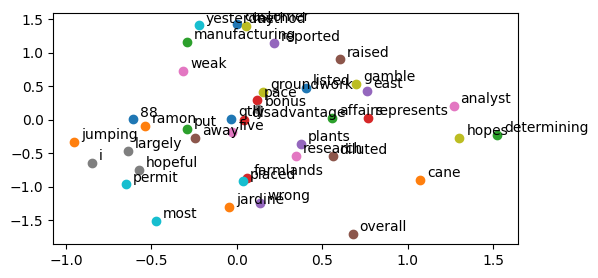

In [30]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs[40:80]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [43]:
cane = get_embed('cane')
cane

(1.0714093446731567, -0.8974266052246094)

In [38]:
commodity = get_embed('commodity')
commodity

(-0.16071438789367676, -0.19759634137153625)

In [39]:
unk = get_embed('<UNK>')
unk

(-1.1641836166381836, 0.3215302526950836)

In [44]:
np.array(cane) @ np.array(unk)

-1.5358670089347015

In [45]:
np.array(cane) @ np.array(commodity)

0.005137316829149086

In [47]:
def cosine_similarity(A, B):
    # Compute the cosine similarity between vectors A and B
    dot_product = np.dot(A, B)  # Compute the dot product of A and B
    norm_a = np.linalg.norm(A)  # Compute the L2 norm (Euclidean norm) of vector A
    norm_b = np.linalg.norm(B)  # Compute the L2 norm (Euclidean norm) of vector B
    similarity = dot_product / (norm_a * norm_b)  # Compute the cosine similarity
    return similarity  # Return the cosine similarity

# Example usage of the cosine_similarity function
print(cosine_similarity(np.array(cane), np.array(unk)))  
print(cosine_similarity(np.array(cane), np.array(commodity)))  

-0.9098843721914851
0.01443175953664608


The cosine similarity results indicate:

- A similarity of approximately -0.9098843721914851 between cane and unk suggests they are quite dissimilar or oppositely directed.
- A similarity of 0.01443175953664608 between cane and commodity implies a  degree of similarity, suggesting similar meanings or contexts.

In [26]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim
print(cos_sim(np.array(rice), np.array(unk)))  # Print the similarity between 'business' and 'unk'
print(cos_sim(np.array(rice), np.array(commodity)))  # Print the similarity between 'business' and 'economics'

-0.9220474076027145
0.6874584642924795


## 7. Saving Word-Index, Corpus , Embedding Model and Configureation for future-application

#### Saving Word-Index Mappings

To ensure the persistence of our word-index mappings and to facilitate their use in future sessions or applications, we save the `word2index` and `index2word` dictionaries to JSON files. 

In [48]:
word2index_path = './config_model_files/word2index_neg_sam.json'  # Define the file path for word2index
index2word_path = './config_model_files/index2word_neg_sam.json'  # Define the file path for index2word

with open(word2index_path, 'w') as file:
    json.dump(word2index, file)  # Save the word2index dictionary to a JSON file

with open(index2word_path, 'w') as file:
    json.dump(index2word, file)  # Save the index2word dictionary to a JSON file


#### Saving the Preprocessed Corpus

After preprocessing the corpus (tokenization, cleaning, etc.), it's good practice to save it for future use. The corpus is saved in a plain text format, making it easily accessible and readable.


In [49]:
corpus_path = './config_model_files/corpus_neg_sam.txt'  # Define the file path for the corpus

with open(corpus_path, 'w') as file:
    for sentence in corpus:
        file.write(' '.join(sentence) + '\n')  # Write each sentence to the file, separated by a newline


#### Saving Word2Vec Model and Configuration

To ensure the preservation and reusability of our Word2Vec model, we save both its state and configuration to separate files.

1. **Saving Model State**: We save the state of the Word2Vec model using `torch.save()`. This includes the learned parameters and embeddings.

2. **Saving Configuration**: We save the model's configuration, such as vocabulary size (`voc_size`) and embedding size (`emb_size`), to a JSON file. 

In [50]:
# Model parameters
voc_size = len(word2index)
emb_size = emb_size  # or whatever was our configuration

# Save the model state and configuration
model_path = './config_model_files/word2vec_model_neg_sam.pth'
config_path = './config_model_files/word2vec_config_neg_sam.json'
torch.save(model.state_dict(), model_path)

with open(config_path, 'w') as config_file:
    config = {'voc_size': voc_size, 'emb_size': emb_size}
    json.dump(config, config_file)

print(f"Model saved to {model_path}")
print(f"Configuration saved to {config_path}")


Model saved to ./config_model_files/word2vec_model_neg_sam.pth
Configuration saved to ./config_model_files/word2vec_config_neg_sam.json


## 8. Inference (Loading Model with an Application of Query-Based Passage Retrieval from Trained Corpus)

here's a simplified high-level overview of the process in less than five steps:

- Preprocess and Embed: Convert the input query and each passage in the corpus into numerical embeddings by averaging their word embeddings.
- Calculate Similarities: Compute the similarity between the query's embedding and each passage's embedding using the dot product.
- Rank Passages: Rank the passages based on their similarity scores with the query.
- Retrieve Top Passages: Select and return the top N passages that have the highest similarity scores with the query.

#### Loading Word-Index Mappings

In [51]:
word2index_path = './config_model_files/word2index_neg_sam.json'  
index2word_path = './config_model_files/index2word_neg_sam.json' 

with open(word2index_path, 'r') as file:
    word2index = json.load(file)  # Load the word2index dictionary from the JSON file

with open(index2word_path, 'r') as file:
    index2word = json.load(file)  # Load the index2word dictionary from the JSON file


#### Loading the Preprocessed Corpus

In [53]:
corpus_path = './config_model_files/corpus_neg_sam.txt' 
def load_corpus(file_path):
    corpus = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Strip removes leading/trailing whitespace
            line = line.strip()
            # print(line)
            if line:  # Add non-empty lines to the corpus
                corpus.append(line)
    return corpus

# Load the corpus
corpus = load_corpus(corpus_path)


In [ ]:
len(corpus)

500

#### Loading Word2Vec Model and Configuration

To use a previously trained Word2Vec model, we load both its configuration and state dictionary. This allows us to recreate the model with the same architecture and settings as before. The process involves:

1. **Loading Configuration**: We load the model's configuration from a JSON file, which includes parameters such as vocabulary size (`voc_size`) and embedding size (`emb_size`).

2. **Initializing Model**: We initialize a new Word2Vec model with the loaded configuration, creating a model that matches the original settings.

3. **Loading Model State**: We load the state dictionary (learned parameters and embeddings) into the initialized model. This restores the model's weights to their trained values.

4. **Setting Model to Evaluation Mode**: We set the loaded model to evaluation mode using `model.eval()`. This mode is typically used when making predictions rather than training.

After loading, we confirm the successful loading of the model.


In [54]:
model_path = './config_model_files/word2vec_model_neg_sam.pth'
config_path = './config_model_files/word2vec_config_neg_sam.json'

# Load the model's configuration from a JSON file
with open(config_path, 'r') as config_file:
    config = json.load(config_file)

# Retrieve the configuration values
voc_size = config['voc_size']  # Vocabulary size
emb_size = config['emb_size']  # Embedding size

# Initialize a new Word2Vec model with the loaded configuration
loaded_model = SkipgramNeg(voc_size, emb_size)

# Load the state dictionary (model parameters) into the initialized model
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (useful for inference)
loaded_model.eval()

# Confirm successful model loading
print("Model loaded successfully")

Model loaded successfully


##### Converts the entire text to lowercase to ensure uniformity of the proprocess we used during the training

In [55]:
def preprocess(text):
    # Tokenizes the text into words. 
    tokens = nltk.word_tokenize(text.lower())  
    return tokens  # Returns the list of tokens obtained from the input text.


The get_embedding function converts text into an average word embedding by:
- Tokenizing the text and retrieving individual word embeddings from the model.
- Averaging these embeddings to represent the entire text.
- Returning this average embedding as a flattened 1-dimensional array, suitable for language processing tasks.

In [56]:

def get_embedding(text, model, word2index):
    """
    Converts a text input to its corresponding average embedding.
    """
    tokens = preprocess(text)  # Preprocess the text to get tokens
    embeddings = []

    # Retrieve and average the center and outside embeddings for the token
    for token in tokens:
        index = word2index.get(token, word2index.get('<UNK>'))
        word_tensor = torch.LongTensor([index])

        embed_center = model.embedding_center(word_tensor)
        embed_outside = model.embedding_outside(word_tensor)
        embed = (embed_center + embed_outside) / 2
        embeddings.append(embed.detach().numpy())
    
    # Average the embeddings to get a single embedding for the entire text
    if embeddings:
        embeddings = np.array(embeddings)
        text_embedding = np.mean(embeddings, axis=0)

    # Make sure the embedding is a 1-D array
    text_embedding = text_embedding.flatten()  # Flatten the array to ensure it's 1-D
    
    return text_embedding


##### The retrieve_top_passages function is designed to find passages in a corpus that are most similar to a given query.  Here's a summary of its key operations:

- Query Embedding: Converts the input query into a numerical embedding.

- Similarity Computation: For each passage in the corpus, the function computes its embedding and then calculates the similarity to the query embedding. The similarity is typically measured using the dot product, representing how close or relevant a passage is to the query.

- Passage Ranking: The passages are then ranked based on their similarity scores. The higher the score, the more relevant the passage is to the query.

- Top Passages Retrieval: Finally, the function retrieves the top N passages with the highest similarity scores.

In [57]:
def retrieve_top_passages(query, corpus, model, word2index, top_n=10):
    """
    Computes the dot product between the input query and each passage in the corpus,
    and retrieves the top N most similar passages.
    """
    # Convert the input query into its embedding
    query_embedding = get_embedding(query, model, word2index)
    similarities = []

    # Compute similarity between the query embedding and each passage's embedding in the corpus

    for passage in corpus:
        passage_embedding = get_embedding(passage, model, word2index)
        # Dot product as a similarity measure
        similarity = np.dot(query_embedding, passage_embedding)
        similarities.append(similarity)

    # Sort the indices of passages based on their similarity scores
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    top_indices = sorted_indices[:top_n]

    # Retrieve the top N passages along with their similarity scores
    top_passages = [(corpus[idx], (similarities[idx]) * 100) for idx in top_indices]
    
    return top_passages

In [67]:
# Example usage with the retrieve_top_passages function
query = "taiwan had a trade trade surplus of how much billion dlrs last year"
print('Search query: ', query)

top_passages = retrieve_top_passages(query, corpus, loaded_model, word2index, top_n=10)
i = 1

print("Similar Passages from Corpus with similarity score")
for passage, score in top_passages:
    print(i, passage,'\t\t\t\t\t\t', score)
    i+= 1

Search query:  taiwan had a trade trade surplus of how much billion dlrs last year
Similar Passages from Corpus with similarity score
1 soybean output . 						 9.28277000784874
2 conrac corp said it has entered talks on its acquisition with several parties conrac corp said it has entered talks on its acquisition with several parties 						 8.96318033337593
3 bowater reported a 32 . 4 mln stg profit in 1985 . 						 8.901199698448181
4 he said at a meeting of ec states ' representatives here yesterday , britain undertook to communicate its own decision to its partners today . 						 8.376453816890717
5 unilever aquired chesebrough for 3 . 2 billion dlrs in order to benefit from its well - known toiletry brands and food products . 						 8.239127695560455
6 beef and citrus imports . 						 8.095347136259079
7 the new shares will rank for dividends declared after october 31 . 						 7.208765298128128
8 total membership of the exchange is now nine brokers and 44 traders . 						 6.80257305

The search aimed to find the specific value of Taiwan's trade surplus from the last year.
- The model provided a list of passages related to business and finance.
- None of the top passages directly answered the query about Taiwan's trade surplus.
- The results indicate the model's ability to retrieve financially related content.

**However, pinpointing precise numerical data or directly responding to specific factual queries remains a challenge.
This highlights the need for model improvement in terms of specificity and data extraction accuracy.**